<h1>Chapter 9 - Multimodal Large Language Models</h1>
<i>Adding vision capabilities to Large Language Models.</i>

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961"><img src="https://img.shields.io/badge/Buy%20the%20Book!-grey?logo=amazon"></a>
<a href="https://www.oreilly.com/library/view/hands-on-large-language/9781098150952/"><img src="https://img.shields.io/badge/O'Reilly-white.svg?logo=data:image/svg%2bxml;base64,PHN2ZyB3aWR0aD0iMzQiIGhlaWdodD0iMjciIHZpZXdCb3g9IjAgMCAzNCAyNyIgZmlsbD0ibm9uZSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIj4KPGNpcmNsZSBjeD0iMTMiIGN5PSIxNCIgcj0iMTEiIHN0cm9rZT0iI0Q0MDEwMSIgc3Ryb2tlLXdpZHRoPSI0Ii8+CjxjaXJjbGUgY3g9IjMwLjUiIGN5PSIzLjUiIHI9IjMuNSIgZmlsbD0iI0Q0MDEwMSIvPgo8L3N2Zz4K"></a>
<a href="https://github.com/HandsOnLLM/Hands-On-Large-Language-Models"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HandsOnLLM/Hands-On-Large-Language-Models/blob/main/chapter09/Chapter%209%20-%20Multimodal%20Large%20Language%20Models.ipynb)

---

This notebook is for Chapter 9 of the [Hands-On Large Language Models](https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961) book by [Jay Alammar](https://www.linkedin.com/in/jalammar) and [Maarten Grootendorst](https://www.linkedin.com/in/mgrootendorst/).

---

<a href="https://www.amazon.com/Hands-Large-Language-Models-Understanding/dp/1098150961">
<img src="https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/images/book_cover.png" width="350"/></a>

### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---


In [ ]:
# %%capture
# !pip install matplotlib transformers datasets accelerate sentence-transformers

## CLIP

In [ ]:
from urllib.request import urlopen
from PIL import Image

# Load an AI-generated image of a puppy playing in the snow
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the snow"

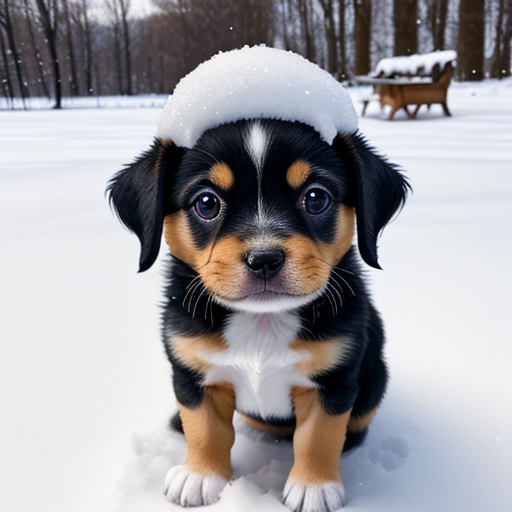

In [ ]:
image

### Embeddings

In [ ]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Load a tokenizer to preprocess the text
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# Load a processor to preprocess the images
clip_processor = CLIPProcessor.from_pretrained(model_id)

# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
# Tokenize our input
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
# Convert our input back to tokens
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [ ]:
# Create a text embedding
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [ ]:
# Preprocess image
processed_image = clip_processor(
    text=None, images=image, return_tensors='pt'
)['pixel_values']

processed_image.shape

torch.Size([1, 3, 224, 224])

(-0.5, 223.5, 223.5, -0.5)

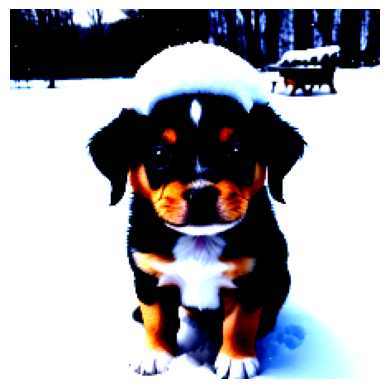

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Prepare image for visualization
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum('ijk->jik', img)

# Visualize preprocessed image
plt.imshow(img)
plt.axis('off')

In [ ]:
# Create the image embedding
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [ ]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = text_embedding @ image_embedding.T
score

array([[0.33149636]], dtype=float32)

### More Images

In [ ]:
from urllib.request import urlopen
from PIL import Image

# Load an AI-generated image of a puppy playing in the snow
cat_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
paths = [puppy_path, cat_path, car_path]
images = [Image.open(urlopen(path)).convert("RGBA") for path in paths]
captions = [
    "a puppy playing in the snow",
    "a pixelated image of a cute cat",
    "A supercar on the road \nwith the sunset in the background"
]

import numpy as np

# Embed all images
image_embeddings = []
for image in images:
  image_processed = clip_processor(images=image, return_tensors='pt')['pixel_values']
  image_embedding = model.get_image_features(image_processed).detach().cpu().numpy()[0]
  image_embeddings.append(image_embedding)
image_embeddings = np.array(image_embeddings)

# Embed all captions
text_embeddings = []
for caption in captions:
  inputs = clip_tokenizer(caption, return_tensors="pt")
  text_emb = model.get_text_features(**inputs).detach().cpu().numpy()[0]
  text_embeddings.append(text_emb)
text_embeddings = np.array(text_embeddings)

In [ ]:
# Calculate cosine similarity between images and captions
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(image_embeddings, text_embeddings)

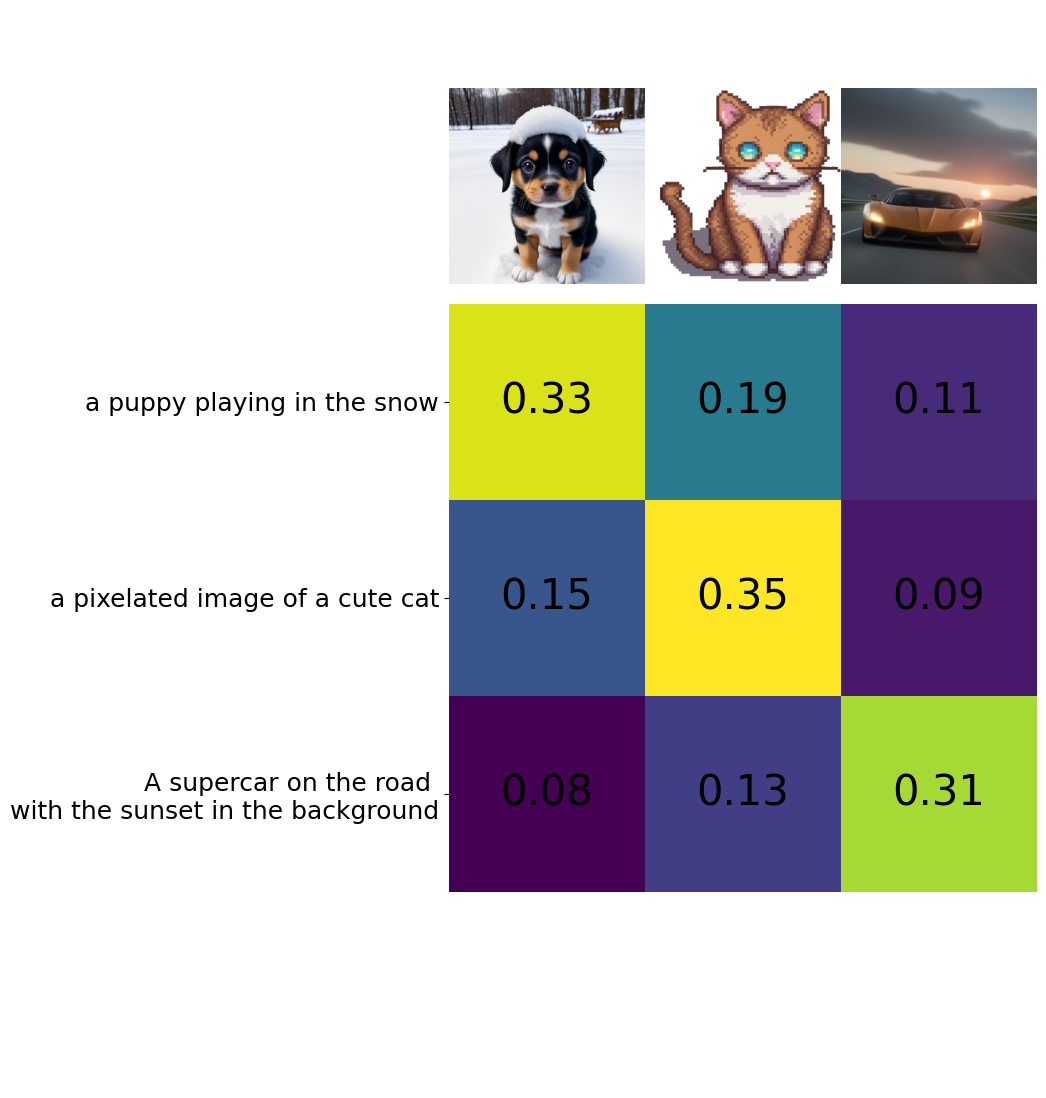

In [ ]:
# Create base figure
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# Adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# Visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# Remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# Resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=20)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')

### SBERT

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load SBERT-compatible CLIP model
model = SentenceTransformer('clip-ViT-B-32')

# Encode the images
image_embeddings = model.encode(images)

# Encode the captions
text_embeddings = model.encode(captions)

#Compute cosine similarities
sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
print(sim_matrix)

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tensor([[0.3315, 0.1863, 0.1084],
        [0.1488, 0.3463, 0.0947],
        [0.0762, 0.1260, 0.3098]])


## BLIP-2

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load processor and main model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16
)

# Send the model to GPU to speed up inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

### Preprocessing Images

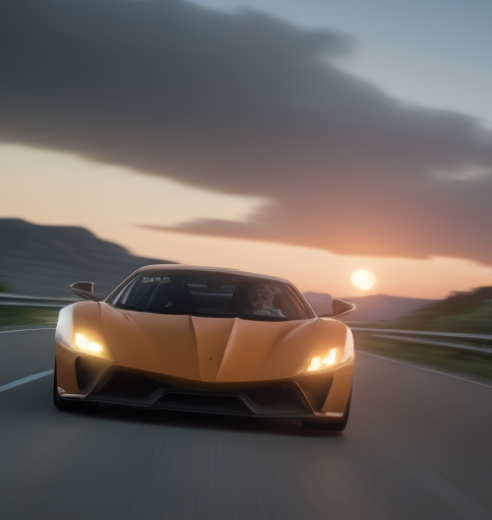

In [ ]:
# Load image of a supercar
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [ ]:
# Preprocess the image
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

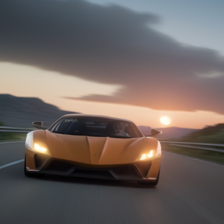

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Convert to numpy and go from (1, 3, 224, 224) to (224, 224, 3) in shape
image_inputs = inputs["pixel_values"][0].detach().cpu().numpy()
image_inputs = np.einsum('ijk->kji', image_inputs)
image_inputs = np.einsum('ijk->jik', image_inputs)

# Scale image inputs to 0-255 to represent RGB values
scaler = MinMaxScaler(feature_range=(0, 255))
image_inputs = scaler.fit_transform(image_inputs.reshape(-1, image_inputs.shape[-1])).reshape(image_inputs.shape)
image_inputs = np.array(image_inputs, dtype=np.uint8)

# Convert numpy array to Image
Image.fromarray(image_inputs)

### Preprocessing Text

In [ ]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [ ]:
# Preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]

# Convert input ids back to tokens
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['</s>', 'Her', 'Ġvocal', 'ization', 'Ġwas', 'Ġremarkably', 'Ġmel', 'odic']

In [ ]:
# Replace the space token with an underscore
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['</s>', 'Her', '_vocal', 'ization', '_was', '_remarkably', '_mel', 'odic']

### Use Case 1: Image Captioning

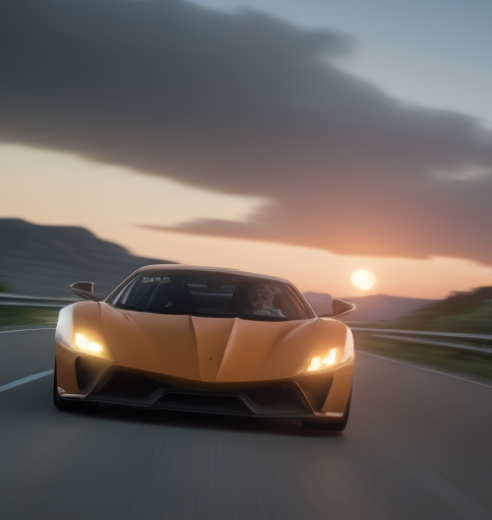

In [ ]:
# Load an AI-generated image of a supercar
image = Image.open(urlopen(car_path)).convert("RGB")

# Convert an image into inputs and preprocess it
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
image

In [ ]:
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs, max_new_tokens=20)

# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'an orange supercar driving on the road at sunset'

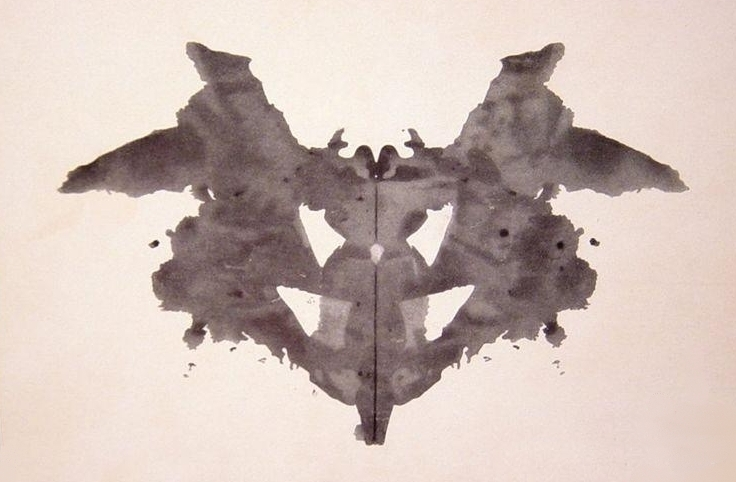

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")
image

In [ ]:
# Load rorschach image
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# Generate caption
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'a black and white ink drawing of a bat'

### Use Case 2: Visual Question Answering

In [ ]:
# Load an AI-generated image of a supercar
image = Image.open(urlopen(car_path)).convert("RGB")

In [ ]:
# Visual Question Answering
prompt = "Question: Write down what you see in this picture. Answer:"

# Process both the image and the prompt
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

# Generate text
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Both `max_new_tokens` (=30) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'A sports car driving on the road at sunset'

In [ ]:
# Chat-like prompting
prompt = "Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer:"

# Generate output
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

Both `max_new_tokens` (=30) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


'$1,000,000'

In [ ]:
from IPython.display import HTML, display
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""

    # Create prompt
    if not memory:
      prompt = " Question: " + question + " Answer:"
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join(
          [
              template.format(memory[i][0], memory[i][1])
              for i in range(len(memory))
          ]
      ) + " Question: " + question + " Answer:"

    # Generate text
    inputs = blip_processor(image, text=prompt, return_tensors="pt")
    inputs = inputs.to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )
    generated_text = generated_text[0].strip().split("Question")[0]

    # Update memory
    memory.append((question, generated_text))

    # Assign to output
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# Display chat box
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)